In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt

def cleantext(text):
    return text.get_text().strip("\n").replace("\xa0", "").split("\n")

def parse_into_dataframe(fromDate, toDate):
    urlbase = "https://w2.brreg.no/kunngjoring/kombisok.jsp?datoFra="
    urlmid = "&datoTil="
    url_end = "&id_region=0&id_niva1=51&id_niva2=56&id_bransje1=0"

    url = urlbase + fromDate + urlmid + toDate + url_end

    body = requests.get(url).content

    soup = BeautifulSoup(body, 'html.parser')

    #locate the relevant table, and display all table rows in it
    myTable = soup.find_all("table", style="border-color: #999999;")
    trs = myTable[0].find_all("tr")

    #remove newlines and other unwanted garbage
    cleanlist = [cleantext(x) for x in trs]

    #The table rows we want have exactly 12 elements each
    strippedlist = [item for item in cleanlist if len(item) == 12]

    #Only 4 of the 12 elements in the rows contain useful information
    #We remove all unwanted elements from each individual row
    relevantFields = [1, 4, 6, 8]
    relevantlist = [[row[i] for i in relevantFields] for row in strippedlist]

    #Remove annoying trailing whitespaces
    finishedlist = [[element.strip() for element in row] for row in relevantlist]

    return pd.DataFrame(finishedlist, columns=['name', 'number', 'date', 'status'])




In [2]:
#Get the html body we want to scrape

date_from_2019 = "01.01.2019"
date_to_2019 = "30.09.2019"
date_from_2020 = "01.01.2020"
date_to_2020 = "30.09.2020"


In [3]:
bankruptcies2019 = parse_into_dataframe(date_from_2019, date_to_2019)



In [4]:
bankruptcies2020 = parse_into_dataframe(date_from_2020, date_to_2020)


In [5]:
bankruptcies2019['date'] = pd.to_datetime(bankruptcies2019['date'], dayfirst=True)
bankruptcies2020['date'] = pd.to_datetime(bankruptcies2020['date'], dayfirst=True)


In [6]:
bankruptcies2019 = bankruptcies2019.sort_values(by='date')
bankruptcies2020 = bankruptcies2020.sort_values(by='date')


In [7]:
bankruptcies2019['month']  = pd.DatetimeIndex(bankruptcies2019['date']).month
bankruptcies2020['month']  = pd.DatetimeIndex(bankruptcies2020['date']).month
bankruptcies2019['day']  = pd.DatetimeIndex(bankruptcies2019['date']).day
bankruptcies2020['day']  = pd.DatetimeIndex(bankruptcies2020['date']).day

In [8]:
bankruptcies2019['count']  = 1
bankruptcies2020['count']  = 1

In [9]:
group2019 = bankruptcies2019.groupby(bankruptcies2019['month']).size().reset_index(name='2019')
group2020 = bankruptcies2020.groupby(bankruptcies2020['month']).size().reset_index(name='2020')


In [10]:
cumsum2019 = group2019.set_index('month').cumsum()
cumsum2020 = group2020.set_index('month').cumsum()

# Bankruptcies in Norway, 2019 vs 2020

[Text(0, 0, 'January'),
 Text(0, 0, 'February'),
 Text(0, 0, 'March'),
 Text(0, 0, 'April'),
 Text(0, 0, 'May'),
 Text(0, 0, 'June'),
 Text(0, 0, 'July'),
 Text(0, 0, 'August'),
 Text(0, 0, 'September')]

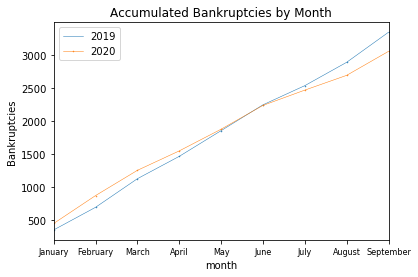

In [11]:
ax = plt.gca()

# Defines labels for the x and y axis, and title
ax.set_xlabel("Month")
ax.set_ylabel("Bankruptcies")
ax.set_title("Accumulated Bankruptcies by Month")

# Defines a background grid, and how many ticks per axis
plt.grid(b=True, linewidth=0.5)

# plots the datasets
cumsum2019.plot(kind="line", y="2019", ax=ax, linewidth=0.5, marker=".", markersize=1)
cumsum2020.plot(kind="line", y="2020", ax=ax, linewidth=0.5, marker=".", markersize=1)

plt.xticks(range(1,10), fontsize=8)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September'])


When we compare the number of bankcruptcies in Norway from january to september in 2019 and 2020, we see no correlation before and after covid19.